# Example Run of LIGNIN-KMC
Written by: Michael Orella <br>
23 January 2019 <br>
Brief examples of how to use the LIGNIN-KMC package within python

In [1]:
%load_ext autoreload
%autoreload 2

Install LIGNIN-KMC

In [2]:
import ligninkmc as kmc
import numpy as np

## SG Lignin Example

The first step of this example is for us to define the rates of bond formation. This is done by using a dictionary that maps the bond string ('5o4','bo4','b5','55','bb','ao4',etc...) to a dictionary that maps monomer type (0 - coniferyl, 1 - sinapyl, 2 - caffeoyl) to a dictionary that maps fragment sizes ('monomer','dimer') to the transition state energy in kcal/mol. These values can be tuned and updated to reflect new developments in better understanding of lignin chemistry. Once the values have been input, they are converted from units of kcal/mol to units of joule/molecule. From this point, they are used in the Eyring equation to calculate an equivalent dictionary of dictionaries of dictionaries of rates.

$$ r_i = \dfrac{k_BT}{h}\exp\left(-\dfrac{\Delta G_i}{k_BT}\right) $$

In [3]:
kb = 1.38064852e-23 # J / K
h = 6.62607004e-34 # J s
temp = 298.15 #K
kcalToJoule = 4184 / 6.022140857e23

#Energies input in kcal/mol
energies = {'5o4':{(0,0):{('monomer','monomer'):11.2,('monomer','dimer'):14.6,
                          ('dimer','monomer'):14.6,('dimer','dimer'):4.4},
                   (1,0):{('monomer','monomer'):10.9,('monomer','dimer'):14.6,
                          ('dimer','monomer'):14.6,('dimer','dimer'):4.4}},
            '55':{(0,0):{('monomer','monomer'):12.5,('monomer','dimer'):15.6,
                          ('dimer','monomer'):15.6,('dimer','dimer'):3.8}},
            'b5':{(0,0):{('monomer','monomer'):5.5,('monomer','dimer'):5.8,
                          ('dimer','monomer'):5.8,('dimer','dimer'):5.8},
                  (0,1):{('monomer','monomer'):5.5,('monomer','dimer'):5.8,
                          ('dimer','monomer'):5.8,('dimer','dimer'):5.8}},
            'bb':{(0,0):{('monomer','monomer'):5.2,('monomer','dimer'):5.2,('dimer','monomer'):5.2,('dimer','dimer'):5.2},
                  (1,0):{('monomer','monomer'):6.5,('monomer','dimer'):6.5,('dimer','monomer'):6.5,('dimer','dimer'):6.5},
                  (1,1):{('monomer','monomer'):5.2,('monomer','dimer'):5.2,('dimer','monomer'):5.2,('dimer','dimer'):5.2}},
            'bo4':{(0,0):{('monomer','monomer'):6.3,('monomer','dimer'):6.2,
                          ('dimer','monomer'):6.2,('dimer','dimer'):6.2},
                   (1,0):{('monomer','monomer'):9.1,('monomer','dimer'):6.2,
                          ('dimer','monomer'):6.2,('dimer','dimer'):6.2},
                   (0,1):{('monomer','monomer'):8.9,('monomer','dimer'):6.2,
                          ('dimer','monomer'):6.2,('dimer','dimer'):6.2},
                   (1,1):{('monomer','monomer'):9.8,('monomer','dimer'):10.4,
                          ('dimer','monomer'):10.4}, ('dimer','dimer'):10.4},
            'ao4':{(0,0):{('monomer','monomer'):20.7,('monomer','dimer'):20.7,
                          ('dimer','monomer'):20.7,('dimer','dimer'):20.7},
                   (1,0):{('monomer','monomer'):20.7,('monomer','dimer'):20.7,
                          ('dimer','monomer'):20.7,('dimer','dimer'):20.7},
                   (0,1):{('monomer','monomer'):20.7,('monomer','dimer'):20.7,
                          ('dimer','monomer'):20.7,('dimer','dimer'):20.7},
                   (1,1):{('monomer','monomer'):20.7,('monomer','dimer'):20.7,
                          ('dimer','monomer'):20.7,('dimer','dimer'):20.7}},
            'b1':{(0,0):{('monomer','dimer'):9.6,
                          ('dimer','monomer'):9.6,('dimer','dimer'):9.6},
                  (1,0):{('monomer','dimer'):11.7,
                          ('dimer','monomer'):11.7,('dimer','dimer'):11.7},
                  (0,1):{('monomer','dimer'):10.7,
                          ('dimer','monomer'):10.7,('dimer','dimer'):10.7},
                  (1,1):{('monomer','dimer'):11.9,
                          ('dimer','monomer'):11.9,('dimer','dimer'):11.9}},
            'ox':{0:{'monomer':0.9,'dimer':6.3},1:{'monomer':0.6,'dimer':2.2}},
            'q':{0:{'monomer':11.1,'dimer':11.1},1:{'monomer':11.7,'dimer':11.7}}}
energies['bb'][(0,1)] = energies['bb'][(1,0)]

#Correct units of the energies
energiesj = {bond : {monType : {size : energies[bond][monType][size] * kcalToJoule for size in energies[bond][monType]}
                    for monType in energies[bond] } 
            for bond in energies }

#Calculate the rates of reaction
rates = {bond : {monType : { size : kb * temp / h * np.exp ( - energiesj[bond][monType][size] / kb / temp ) 
                            for size in energies[bond][monType]} 
                 for monType in energies[bond] }
         for bond in energies}

With the rates generated, it is now time to initialize the simulation with a set of monomers, and the ratio of S and G units that should be incorporated. 

In [4]:
sg = 1
n = 2

pct = sg / (1 + sg)

rands = np.random.rand(n)
mons = [ kmc.Monomer( int ( sOrG < pct ) , i ) for i,sOrG in zip ( range(n) , rands ) ]
startEvents = [ kmc.Event ( 'ox' , [i] , rates['ox'][ int( sOrG < pct ) ]['monomer'] ) for i,sOrG in zip ( range(n) , rands) ]

When the monomers and starting events have been initialized, they are grouped into the "state" and "events" which are necessary to start the simulation. The final pieces of information needed to run the simulation are the maximum number of monomers that should be studied and the final simulation time. In this case, we choose a simulation time of 1 second, and a maximum number of monomers of 10. Once these parameters are set, we can go about running the simulation. To show the state, we will print the adjacency matrix that has been generated, although this is not the typical output examined.

In [5]:
state = { i : {'mon' : mons[i] , 'affected' : {startEvents[i]} } for i in range(n) }
events = { startEvents[i] for i in range(n) }
events.add(kmc.Event('grow',[],rate = 1e4,bond = sg))

res = kmc.run(nMax = 10,tFinal = 1, rates = rates, initialState = state, initialEvents = events)
print(res['adjacency_matrix'].todense())

[[0. 8. 4. 0. 0. 0. 0. 0. 0. 0.]
 [5. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [8. 0. 0. 4. 0. 0. 0. 0. 0. 0.]
 [0. 0. 8. 0. 5. 0. 0. 0. 0. 0.]
 [0. 0. 0. 8. 0. 5. 0. 0. 0. 0.]
 [0. 0. 0. 0. 8. 0. 4. 0. 0. 0.]
 [0. 0. 0. 0. 0. 8. 0. 5. 0. 0.]
 [0. 0. 0. 0. 0. 0. 8. 0. 4. 0.]
 [0. 0. 0. 0. 0. 0. 0. 8. 0. 4.]
 [0. 0. 0. 0. 0. 0. 0. 0. 8. 0.]]


With our results in place, we go about analyzing them using the "analyze" functionality.

In [6]:
nodes = res['monomers']
adj = res['adjacency_matrix']
kmc.analyze(adjacency = adj, nodes = nodes)

{'Chain Lengths': Counter({10: 1}),
 'Bonds': {'bo4': 5, 'b1': 0, 'bb': 0, 'b5': 4, '55': 0, 'ao4': 0, '5o4': 0},
 'RCF Yields': Counter({2: 2, 1: 3, 3: 1}),
 'RCF Bonds': {'bo4': 0,
  'b1': 0,
  'bb': 0,
  'b5': 4,
  '55': 0,
  'ao4': 0,
  '5o4': 0}}

While the analysis is nice for the purpose of seeing the kinds of macroscopic results, but we can use the RDKit package to visualize the molecular fragments.

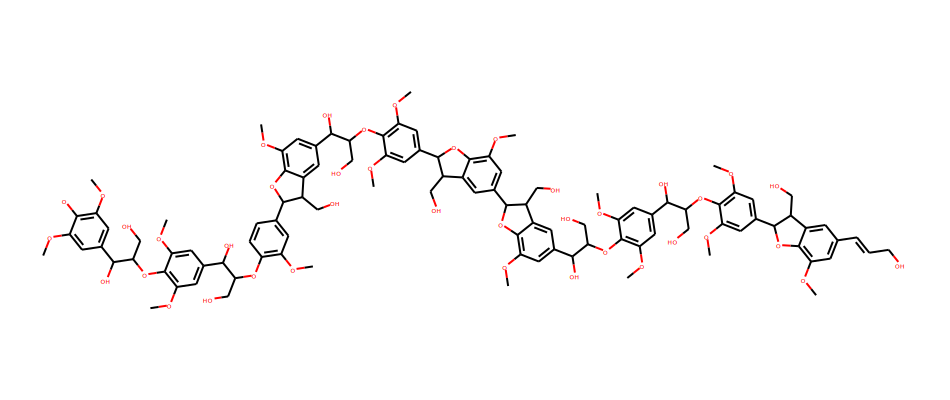

In [7]:
from rdkit import Chem
from rdkit.Chem import AllChem
from IPython.display import SVG
block = kmc.generateMol(adj,nodes)
mol = Chem.MolFromMolBlock(block)
AllChem.Compute2DCoords(mol)
SVG(kmc.moltosvg(mol,molSize=(950,400)))

These results presented above will be dependent on each of the parameters that are chosen. Play around with the values of the parameters to see how the final structure changes. We will now go through a similar example using C-lignin instead of SG-lignin.

## C Lignin Example

In [8]:
cLigEnergies = {'5o4':{(2,2):{('monomer','monomer'):11.9,('monomer','dimer'):11.9,
                          ('dimer','monomer'):11.9,('dimer','dimer'):11.9}},
            '55':{(2,2):{('monomer','monomer'):10.6,('monomer','dimer'):10.6,
                          ('dimer','monomer'):10.6,('dimer','dimer'):10.6}},
            'b5':{(2,2):{('monomer','monomer'):1.9,('monomer','dimer'):5.8,
                          ('dimer','monomer'):5.8,('dimer','dimer'):5.8}},
            'bb':{(2,2):{('monomer','monomer'):7.2,('monomer','dimer'):7.2,
                         ('dimer','monomer'):7.2,('dimer','dimer'):7.2}},
            'bo4':{(2,2):{('monomer','monomer'):4.9,('monomer','dimer'):1.3,
                          ('dimer','monomer'):1.3,('dimer','dimer'):1.3}},
            'ao4':{(2,2):{('monomer','monomer'):20.7,('monomer','dimer'):20.7,
                          ('dimer','monomer'):20.7,('dimer','dimer'):20.7}},
            'b1':{(2,2):{('monomer','dimer'):9.6,
                          ('dimer','monomer'):9.6,('dimer','dimer'):9.6}},
            'ox':{2:{'monomer':0.9,'dimer':0.9}},
            'q':{2:{'monomer':11.1,'dimer':11.1}}}

#Correct units of the energies
cLigEnergiesev = {bond : {monType : {size : cLigEnergies[bond][monType][size] * kcalToJoule for size in cLigEnergies[bond][monType]}
                    for monType in cLigEnergies[bond] }
            for bond in cLigEnergies }

#Calculate the rates of reaction
cRates = {bond : {monType : { size : kb * temp / h * np.exp ( - cLigEnergiesev[bond][monType][size] / kb / temp ) 
                            for size in cLigEnergies[bond][monType] } 
                 for monType in cLigEnergies[bond] }
         for bond in cLigEnergies}

In [9]:
n = 2

mons = [ kmc.Monomer( 2 , i ) for i in range(n) ]
startEvents = [ kmc.Event ( 'ox' , [i] , cRates['ox'][ 2 ]['monomer'] ) for i in range(n) ]

state = { i : {'mon' : mons[i] , 'affected' : {startEvents[i]} } for i in range(n)}
events = { startEvents[i] for i in range(n)}
events.add(kmc.Event('grow',[],rate=1e4))

res = kmc.run(nMax = 10,tFinal = 1, rates = cRates, initialState = state, initialEvents = events)
print(res['adjacency_matrix'].todense())

nodes = res['monomers']
adj = res['adjacency_matrix']
kmc.analyze(adjacency = adj, nodes = nodes)

[[0. 8. 4. 0. 0. 0. 0. 0. 0. 0.]
 [5. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [8. 0. 0. 4. 0. 0. 0. 0. 0. 0.]
 [0. 0. 8. 0. 4. 0. 0. 0. 0. 0.]
 [0. 0. 0. 8. 0. 4. 0. 0. 0. 0.]
 [0. 0. 0. 0. 8. 0. 4. 0. 0. 0.]
 [0. 0. 0. 0. 0. 8. 0. 4. 0. 0.]
 [0. 0. 0. 0. 0. 0. 8. 0. 4. 0.]
 [0. 0. 0. 0. 0. 0. 0. 8. 0. 4.]
 [0. 0. 0. 0. 0. 0. 0. 0. 8. 0.]]


{'Chain Lengths': Counter({10: 1}),
 'Bonds': {'bo4': 8, 'b1': 0, 'bb': 0, 'b5': 1, '55': 0, 'ao4': 0, '5o4': 0},
 'RCF Yields': Counter({2: 1, 1: 8}),
 'RCF Bonds': {'bo4': 0,
  'b1': 0,
  'bb': 0,
  'b5': 1,
  '55': 0,
  'ao4': 0,
  '5o4': 0}}

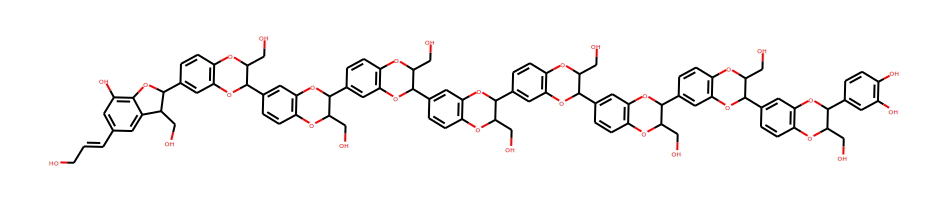

In [10]:
block = kmc.generateMol(adj,nodes)
mol = Chem.MolFromMolBlock(block)
AllChem.Compute2DCoords(mol)
SVG(kmc.moltosvg(mol,molSize=(950,200)))